# Interpolating high grade serous ovarian cancer subtypes in VAE space

Recent applications of generative models (GANs and VAEs) in image processing has demonstrated the remarkable ability of the latent dimensions to capture a meaningful manifold representation of the input space. Here, we assess if the VAE learns a latent space that can be mathematically manipulated to reveal insight into the gene expression activation patterns of high grade serous ovarian cancer (HGSC) subtypes.

Several previous studies have reported the presence of four gene expression based HGSC subtypes. However, we recently [published a paper](https://doi.org/10.1534/g3.116.033514) that revealed the inconsistency of subtype assignments across populations. We observed repeatable structure in the data transitioning between setting clustering algorithms to find different solutions. For instance, when setting algorithms to find 2 subtypes, the mesenchymal and immunoreactive and the proliferative and differentiated subtype consistently collapsed together. These observations may suggest that the subtypes exist on a gene expression continuum of differential activation patterns, and may only be artificially associated with "subtypes". Here, we test if the VAE can help to identify some differential patterns of expression.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import keras

Using TensorFlow backend.


In [2]:
# Save models (full VAE, generator, encoder)
decoder_model_file = os.path.join('models', 'decoder_onehidden_vae.hdf5')
encoder_model_file = os.path.join('models', 'encoder_onehidden_vae.hdf5')

# This is how models will be loaded
# VAE loading is giving errors because of `sampling` function
# vae_loading_test = keras.models.load_model(vae_model_file)
decoder = keras.models.load_model(decoder_model_file)
encoder = keras.models.load_model(encoder_model_file)

/home/gway/anaconda3/lib/python3.5/site-packages/keras/models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
rnaseq_file = os.path.join('data', 'pancan_scaled_zeroone_rnaseq.tsv')
rnaseq_df = pd.read_table(rnaseq_file, index_col=0)
rnaseq_df.shape

(10459, 5000)

In [4]:
ov_df = pd.read_table(os.path.join('data', 'ov_subtype_info.tsv'), index_col=0)
ov_df.head(2)

,DATASET,SUBTYPE,AGE,PLATINUM-STATUS,STAGE,GRADE,TUMORRESIDUALDISEASE,SURVIVALSTATUS,SURVIVALMONTHS,RECURRENCE-STATUS,...,Proliferative ssGSEA raw score,Differentiated ssGSEA normalized score,Immunoreactive ssGSEA normalized score,Mesenchymal ssGSEA normalized score,Proliferative ssGSEA normalized score,Differentiated-binary,Immunoreactive-binary,Mesenchymal-binary,Proliferative-binary,SILHOUETTE WIDTH
ID,,,,,,,,,,,,,,,,,,,,,
TCGA-04-1357-01,TCGA-discovery,Immunoreactive,52.0,unknown,IIIB,G3,unknown,LIVING,unknown,unknown,...,127.0,0.765,0.948,0.406,0.169,1,1,0,0,0.184202
TCGA-04-1519-01,TCGA-discovery,Proliferative,48.0,unknown,IIIC,G3,unknown,unknown,unknown,unknown,...,"2,578.4",0.555,0.128,0.331,0.750,1,0,0,1,0.088401


In [5]:
encoded_df = pd.read_table(os.path.join('data', "encoded_rnaseq_onehidden_warmup_batchnorm.tsv"), index_col=0)
encoded_df.shape

(10459, 100)

In [6]:
# Subset and merge the HGSC subtype info with the latent space feature activations
ov_samples = list(set(encoded_df.index) & (set(ov_df.index)))

ov_encoded = encoded_df.loc[ov_samples, ]
ov_encoded_subtype = pd.merge(ov_df.loc[:, ['SUBTYPE', 'SILHOUETTE WIDTH']], ov_encoded,
                              how='right', left_index=True, right_index=True)
ov_encoded_subtype = ov_encoded_subtype.assign(subtype_color = ov_encoded_subtype['SUBTYPE'])

ov_subtype_color_dict = {'Differentiated': 'purple',
                         'Immunoreactive': 'green',
                         'Mesenchymal': 'blue',
                         'Proliferative': 'red'}
ov_encoded_subtype = ov_encoded_subtype.replace({'subtype_color': ov_subtype_color_dict})

print(ov_encoded_subtype.shape)
ov_encoded_subtype.head(2)

(295, 103)


,SUBTYPE,SILHOUETTE WIDTH,1,2,3,4,5,6,7,8,...,92,93,94,95,96,97,98,99,100,subtype_color
TCGA-24-2289-01,Mesenchymal,0.266828,1.277562,0.0,0.000000,0.0,5.081286,0.000000,0.000000,1.704437,...,2.350034,0.000000,1.449464,0.000000,4.557267,0.0,0.335814,0.000000,0.900380,blue
TCGA-61-2000-01,Immunoreactive,0.101621,0.000000,0.0,0.853533,0.0,4.770956,1.447275,0.566647,3.954801,...,1.882801,0.966238,0.797862,0.446868,1.217325,0.0,0.000000,0.747686,0.034721,green


In [7]:
# Get the HGSC mean feature activation
ov_mean_subtypes = ov_encoded_subtype.groupby('SUBTYPE').mean()
ov_mean_subtypes

,SILHOUETTE WIDTH,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
SUBTYPE,,,,,,,,,,,,,,,,,,,,,
Differentiated,0.009807,1.136645,0.063230,1.084596,0.030669,4.319315,2.162740,0.117676,1.828255,0.147573,...,0.029515,0.870131,0.231958,0.539399,0.306902,1.152863,0.068156,0.134011,2.068712,0.551172
Immunoreactive,0.101423,0.540490,0.098282,1.239212,0.055656,4.013140,0.576003,0.228713,1.508975,0.403625,...,0.102097,0.425375,1.075524,0.976115,1.152676,1.725361,0.015276,0.296640,0.524122,0.868875
Mesenchymal,0.184519,1.141423,0.073041,0.506510,0.063834,3.769120,0.796414,0.089175,2.941976,0.322914,...,0.201935,2.217084,0.235209,0.881876,0.599195,3.461850,0.000000,0.107133,0.603792,1.895198
Proliferative,0.129997,1.384532,0.092532,1.010996,0.332801,3.214791,3.225281,0.033968,4.260623,0.501052,...,0.127314,0.398148,0.247336,0.757045,0.902759,1.298532,0.036185,0.165628,2.275845,0.280951


## HGSC Subtype Math

Because of the relationship observed in the consistent clustering solutions, perform the following subtractions

1. Immunoreactive - Mesenchymal
2. Differentiated - Proliferative

The goal is to observe the features with the largest difference between the aformentioned comparisons. The differences should be in absolute directions

In [8]:
mesenchymal_mean_vector = ov_mean_subtypes.loc['Mesenchymal', [str(x) for x in range(1, 101)]]
immuno_mean_vector = ov_mean_subtypes.loc['Immunoreactive', [str(x) for x in range(1, 101)]]
proliferative_mean_vector = ov_mean_subtypes.loc['Proliferative', [str(x) for x in range(1, 101)]]
differentiated_mean_vector = ov_mean_subtypes.loc['Differentiated', [str(x) for x in range(1, 101)]]

In [9]:
high_immuno = (immuno_mean_vector - mesenchymal_mean_vector).sort_values(ascending=False).head(2)
high_mesenc = (immuno_mean_vector - mesenchymal_mean_vector).sort_values(ascending=False).tail(2)

print("Features with large differences: Immuno high, Mesenchymal low")
print(high_immuno)
print("Features with large differences: Mesenchymal high, Immuno low")
print(high_mesenc)

Features with large differences: Immuno high, Mesenchymal low
77    3.147650
56    2.911636
dtype: float64
Features with large differences: Mesenchymal high, Immuno low
92   -1.791708
87   -3.247565
dtype: float64


In [10]:
# Select to visualize encoding 56 because it has high immuno and low everything else
ov_mean_subtypes.loc[:, ['87', '77', '56']]

,87,77,56
SUBTYPE,,,
Differentiated,2.290071,2.962777,0.882760
Immunoreactive,3.508898,4.956166,3.446800
Mesenchymal,6.756463,1.808515,0.535164
Proliferative,1.197723,4.757647,0.614116


In [11]:
# Obtain the decoder weights
weights = []
for l in decoder.layers:
    weights.append(l.get_weights())
    
weight_layer = pd.DataFrame(weights[1][0], columns=rnaseq_df.columns)
weight_layer.head(2)

,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
0,-0.038720,0.016661,0.029607,0.039584,-0.001849,0.012594,0.016473,0.012619,-0.041976,-0.035155,...,0.015413,-0.021422,-0.009609,-0.016911,0.001458,-0.014941,-0.008457,-0.028340,-0.004947,0.014693
1,-0.038551,0.025872,0.026606,0.014903,0.011040,-0.018997,0.002153,-0.003017,-0.042659,-0.044308,...,-0.007668,0.000821,0.020055,0.012365,0.010221,0.010597,-0.018201,0.031298,-0.014771,-0.012871


In [12]:
# Get the high weight genes
immuno_genes = weight_layer.loc[87, :].sort_values(ascending = False)
immuno_v2_genes = weight_layer.loc[77, :].sort_values(ascending = False)
immuno_v3_genes = weight_layer.loc[56, :].sort_values(ascending = False)

In [13]:
(immuno_genes[immuno_genes >
              immuno_genes.std() * 2]).to_csv(os.path.join('results',
                                                           'hgsc_node87genes_pos.tsv'))
(immuno_genes[immuno_genes <
              -1 * (immuno_genes.std() * 2)]).to_csv(os.path.join('results',
                                                                  'hgsc_node87genes_neg.tsv'))

(immuno_v2_genes[immuno_v2_genes >
                 immuno_v2_genes.std() * 2]).to_csv(os.path.join('results',
                                                                 'hgsc_node77genes_pos.tsv'))
(immuno_v2_genes[immuno_v2_genes <
                 -1 * (immuno_v2_genes.std() * 2)]).to_csv(os.path.join('results',
                                                                        'hgsc_node77genes_neg.tsv'))

(immuno_v3_genes[immuno_v3_genes >
                 immuno_v3_genes.std() * 2]).to_csv(os.path.join('results',
                                                                 'hgsc_node56genes_pos.tsv'))
(immuno_v3_genes[immuno_v3_genes <
                 -1 * (immuno_v3_genes.std() * 2)]).to_csv(os.path.join('results',
                                                                        'hgsc_node56genes_neg.tsv'))

In [14]:
high_differ = (differentiated_mean_vector - proliferative_mean_vector).sort_values(ascending=False).head(2)
high_prolif = (differentiated_mean_vector - proliferative_mean_vector).sort_values(ascending=False).tail(2)

print("Features with large differences: Differentiated high, Proliferative low")
print(high_differ)
print("Features with large differences: Proliferative high, Differentiated low")
print(high_prolif)

Features with large differences: Differentiated high, Proliferative low
38    3.921864
63    3.438013
dtype: float64
Features with large differences: Proliferative high, Differentiated low
8    -2.432367
79   -3.946322
dtype: float64


In [15]:
differ_genes = weight_layer.loc[79, :].sort_values(ascending = False)
differ_v2_genes = weight_layer.loc[38, :].sort_values(ascending = False)

In [16]:
(differ_genes[differ_genes >
              differ_genes.std() * 2]).to_csv(os.path.join('results',
                                                            'hgsc_node79genes_diffpro_pos.tsv'))
(differ_genes[differ_genes <
              -1 * (differ_genes.std() * 2)]).to_csv(os.path.join('results',
                                                                  'hgsc_node79genes_diffpro_neg.tsv'))

(differ_v2_genes[differ_v2_genes >
                 differ_v2_genes.std() * 2]).to_csv(os.path.join('results',
                                                                 'hgsc_node38genes_diffpro_pos.tsv'))
(differ_v2_genes[differ_v2_genes <
                 -1 * (differ_v2_genes.std() * 2)]).to_csv(os.path.join('results',
                                                                        'hgsc_node38genes_diffpro_neg.tsv'))

In [17]:
%matplotlib inline
plt.style.use("seaborn-notebook")

In [18]:
sns.set(style="white", color_codes=True)
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":15,"axes.labelsize":20,
                             'xtick.labelsize':14, 'ytick.labelsize': 14})   

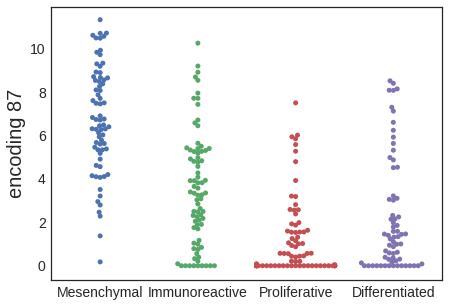

In [19]:
# Node 87 has high mesenchymal, low immunoreactive
g = sns.swarmplot(y = '87', x = 'SUBTYPE', data=ov_encoded_subtype,
                  order=['Mesenchymal', 'Immunoreactive', 'Proliferative', 'Differentiated']);
g.set(xlabel='', ylabel='encoding 87')
plt.xticks(rotation=0);
plt.tight_layout()
plt.savefig(os.path.join('figures', 'node87_distribution_ovsubtype.pdf'))

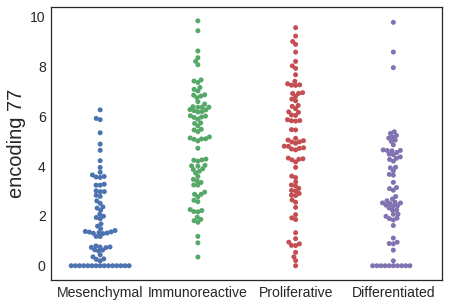

In [20]:
# Node 77 has high immunoreactive, low mesenchymal
g = sns.swarmplot(y = '77', x = 'SUBTYPE', data=ov_encoded_subtype,
                  order=['Mesenchymal', 'Immunoreactive', 'Proliferative', 'Differentiated']);
g.set(xlabel='', ylabel='encoding 77')
plt.xticks(rotation=0);
plt.tight_layout()
plt.savefig(os.path.join('figures', 'node77_distribution_ovsubtype.pdf'))

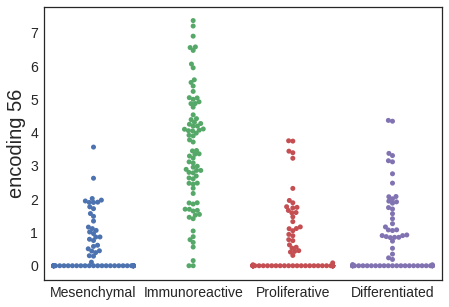

In [21]:
# Node 56 has high immunoreactive, low mesenchymal (but also low proliferative)
g = sns.swarmplot(y = '56', x = 'SUBTYPE', data=ov_encoded_subtype,
                  order=['Mesenchymal', 'Immunoreactive', 'Proliferative', 'Differentiated']);
g.set(xlabel='', ylabel='encoding 56')
plt.xticks(rotation=0);
plt.tight_layout()
plt.savefig(os.path.join('figures', 'node56_distribution_ovsubtype.pdf'))

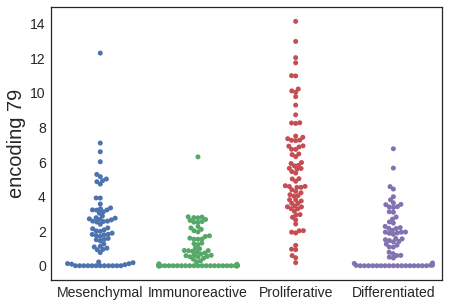

In [22]:
# Node 79 has high proliferative, low differentiated
g = sns.swarmplot(y = '79', x = 'SUBTYPE', data=ov_encoded_subtype,
                  order=['Mesenchymal', 'Immunoreactive', 'Proliferative', 'Differentiated']);
g.set(xlabel='', ylabel='encoding 79')
plt.xticks(rotation=0);
plt.tight_layout()
plt.savefig(os.path.join('figures', 'node79_distribution_ovsubtype.pdf'))

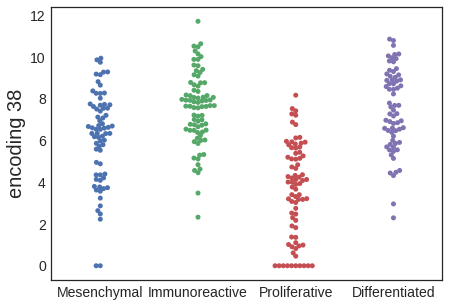

In [23]:
# Node 38 has high differentiated, low proliferative
g = sns.swarmplot(y = '38', x = 'SUBTYPE', data=ov_encoded_subtype,
                  order=['Mesenchymal', 'Immunoreactive', 'Proliferative', 'Differentiated']);
g.set(xlabel='', ylabel='encoding 38')
plt.xticks(rotation=0);
plt.tight_layout()
plt.savefig(os.path.join('figures', 'node38_distribution_ovsubtype.pdf'))